First install necessary libraries and mount google drive.

In [ ]:
!pip install -q transformers accelerate evaluate optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Dataset.

In [ ]:
from datasets import load_dataset, Features, Value, ClassLabel
import pandas as pd

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=6)
})

dataset = load_dataset('csv', data_files={'train': 'drive/MyDrive/CENG481-Project/data/emotions.csv'})

df = pd.DataFrame(dataset['train'])
print(df.head())

Generating train split: 0 examples [00:00, ? examples/s]

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


Check and handle missing values.

In [ ]:
dataset['train'] = dataset['train'].filter(lambda x: x['text'] is not None and x['label'] is not None)
dataset = dataset.cast_column("label", ClassLabel(num_classes=6))

Filter:   0%|          | 0/416809 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/416809 [00:00<?, ? examples/s]

Split data as train, test, validation.

In [ ]:
from datasets import DatasetDict

split_1 = dataset['train'].train_test_split(test_size=0.2, stratify_by_column='label', seed=42)

split_2 = split_1['test'].train_test_split(test_size=0.5, stratify_by_column='label', seed=42)

dataset = DatasetDict({
    'train': split_1['train'],
    'validation': split_2['train'],
    'test': split_2['test'],
})

*Tokenize* dataset

In [ ]:
from transformers import AutoTokenizer

checkpoint = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/333447 [00:00<?, ? examples/s]

Map:   0%|          | 0/41681 [00:00<?, ? examples/s]

Map:   0%|          | 0/41681 [00:00<?, ? examples/s]

Define model with custom classifier head.

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch.nn as nn

dropout_rate = 0.49034896247785176

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=6
)

model.classifier = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.config.hidden_size, 256),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(256, 6)
)

print(model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define evalutaion metrics.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_weighted": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
        "precision_weighted": precision.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall_weighted": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"],
    }

I use Optuna for hyperparameter tuning.

In [ ]:
import optuna
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback
import torch.nn as nn
import numpy as np
from transformers import TrainerCallback
import optuna

class OptunaPruningCallback(TrainerCallback):
    def __init__(self, trial, eval_steps):
        self.trial = trial
        self.eval_steps = eval_steps

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return control
        current_score = metrics.get('eval_f1_weighted')
        if current_score is None:
            return control

        self.trial.report(current_score, step=state.global_step)
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return control

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    per_device_batch_size = trial.suggest_categorical("per_device_batch_size", [8, 16, 32])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    # Model init with updated dropout in classifier
    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint,
        num_labels=6
    )
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.config.hidden_size, 256),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(256, 6)
    )

    # Define training args for this trial
    training_args = TrainingArguments(
      output_dir=f"results_optuna_trial_{trial.number}",
      eval_strategy="steps",
      eval_steps=100,
      logging_strategy="steps",
      logging_steps=100,
      save_strategy="no",
      learning_rate=learning_rate,
      per_device_train_batch_size=per_device_batch_size,
      per_device_eval_batch_size=per_device_batch_size,
      max_steps=1000,
      weight_decay=0.01,
      seed=42,
      fp16=True,
      report_to=None,
      metric_for_best_model="f1_weighted"
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=2),
            OptunaPruningCallback(trial, eval_steps=training_args.eval_steps)
        ],
    )

    trainer.train()
    eval_results = trainer.evaluate()

    # We maximize weighted F1 score
    return eval_results["eval_f1_weighted"]

# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # You can increase n_trials

print("Best trial:")
trial = study.best_trial
print(f"  Value (weighted F1): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-06-02 15:28:03,170] A new study created in memory with name: no-name-2b083bd0-79d4-43f5-8366-62afc90f9ba8
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-f51ed81e4647>:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.655800,1.578416,0.339251,0.177762,0.205418,0.339251
200,1.590100,1.506824,0.495681,0.393010,0.347688,0.495681
300,1.437600,1.280172,0.564539,0.443476,0.372954,0.564539
400,1.288000,1.183624,0.582534,0.458454,0.385741,0.582534
500,1.150100,1.021529,0.659549,0.583007,0.597176,0.659549
600,1.028700,0.925802,0.717610,0.660246,0.631249,0.717610
700,0.908000,0.814351,0.764155,0.713738,0.675645,0.764155
800,0.873500,0.722318,0.788148,0.739314,0.699687,0.788148
900,0.770800,0.655082,0.802063,0.751427,0.709590,0.802063
1000,0.714500,0.645171,0.803503,0.752943,0.712273,0.803503


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1000 is already reported.
  warnings.warn(
[I 2025-06-02 15:34:17,315] Trial 0 finished with value: 0.752943439135711 and parameters: {'learning_rate': 1.0238657338960735e-05, 'per_device_batch_size': 16, 'dropout_rate': 0.37174628309994573}. Best is trial 0 with value: 0.752943439135711.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TR

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.599600,1.577764,0.338532,0.171238,0.114604,0.338532
200,1.584200,1.574071,0.338532,0.171238,0.114604,0.338532
300,1.610300,1.574972,0.338532,0.171238,0.114604,0.338532


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
[I 2025-06-02 15:36:23,954] Trial 1 finished with value: 0.1712379229899345 and parameters: {'learning_rate': 3.403960205237652e-05, 'per_device_batch_size': 16, 'dropout_rate': 0.20252554409621473}. Best is trial 0 with value: 0.752943439135711.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRA

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.623700,1.586330,0.290787,0.131016,0.084557,0.290787
200,1.561200,1.575315,0.338532,0.171238,0.114604,0.338532
300,1.600400,1.580365,0.338532,0.171238,0.114604,0.338532
400,1.580700,1.573847,0.338532,0.171238,0.114604,0.338532


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 400 is already reported.
  warnings.warn(
[I 2025-06-02 15:40:22,853] Trial 2 finished with value: 0.1712379229899345 and parameters: {'learning_rate': 4.71859477887333e-05, 'per_device_batch_size': 8, 'dropout_rate': 0.2477328592296608}. Best is trial 0 with value: 0.752943439135711.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN 

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.774500,1.710555,0.338532,0.171238,0.114604,0.338532
200,1.674100,1.628310,0.338532,0.171238,0.114604,0.338532
300,1.638000,1.591622,0.338532,0.171238,0.114604,0.338532


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
[I 2025-06-02 15:43:30,056] Trial 3 finished with value: 0.1712379229899345 and parameters: {'learning_rate': 1.9175614549472393e-06, 'per_device_batch_size': 8, 'dropout_rate': 0.22073819916645038}. Best is trial 0 with value: 0.752943439135711.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRA

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.607600,1.570666,0.419146,0.326490,0.298226,0.419146
200,1.412000,1.261013,0.554942,0.439927,0.378002,0.554942
300,1.270600,1.122018,0.589251,0.465588,0.394839,0.589251
400,1.097900,1.139817,0.629798,0.607591,0.626628,0.629798
500,0.880200,0.754021,0.789827,0.739313,0.696732,0.789827
600,0.666600,0.498118,0.863004,0.852019,0.874799,0.863004
700,0.474800,0.403556,0.893954,0.888084,0.893498,0.893954
800,0.410900,0.378723,0.904031,0.901897,0.908035,0.904031
900,0.401800,0.337270,0.917226,0.916573,0.918986,0.917226
1000,0.367800,0.331338,0.919626,0.918524,0.920250,0.919626


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1000 is already reported.
  warnings.warn(
[I 2025-06-02 15:49:47,530] Trial 4 finished with value: 0.9185241440054012 and parameters: {'learning_rate': 1.9229513672629163e-05, 'per_device_batch_size': 16, 'dropout_rate': 0.24089400246034104}. Best is trial 4 with value: 0.9185241440054012.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-f51ed81e4647>:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.751800,1.685442,0.338532,0.171238,0.114604,0.338532
200,1.631800,1.592368,0.338532,0.171238,0.114604,0.338532
300,1.606900,1.575772,0.338532,0.171238,0.114604,0.338532


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
[I 2025-06-02 15:52:55,997] Trial 5 finished with value: 0.1712379229899345 and parameters: {'learning_rate': 2.760970769201813e-06, 'per_device_batch_size': 8, 'dropout_rate': 0.17235117211898204}. Best is trial 4 with value: 0.9185241440054012.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRA

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.611300,1.492145,0.510317,0.401212,0.340619,0.510317
200,1.355000,1.224482,0.561660,0.445880,0.385710,0.561660
300,1.158300,1.130553,0.639155,0.546879,0.623741,0.639155
400,0.955300,0.797574,0.754079,0.711051,0.683076,0.754079
500,0.732100,0.604885,0.805902,0.755933,0.713963,0.805902
600,0.521200,0.456752,0.862764,0.859691,0.879715,0.862764
700,0.418200,0.424718,0.889155,0.886563,0.888791,0.889155
800,0.427100,0.346817,0.906910,0.907550,0.909420,0.906910
900,0.367100,0.315156,0.915307,0.914953,0.915079,0.915307
1000,0.321500,0.299038,0.915787,0.915832,0.916125,0.915787


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1000 is already reported.
  warnings.warn(
[I 2025-06-02 15:59:15,452] Trial 6 finished with value: 0.9158324292721078 and parameters: {'learning_rate': 1.7826351957314162e-05, 'per_device_batch_size': 16, 'dropout_rate': 0.15962092204105086}. Best is trial 4 with value: 0.9185241440054012.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-f51ed81e4647>:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.665200,1.585767,0.351727,0.259403,0.220298,0.351727
200,1.555500,1.512378,0.525912,0.408406,0.335013,0.525912
300,1.435400,1.321447,0.546545,0.422430,0.344268,0.546545


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.683700,1.572814,0.338532,0.171238,0.114604,0.338532
200,1.514200,1.347957,0.543186,0.429196,0.368696,0.543186
300,1.307700,1.218205,0.580374,0.455096,0.379989,0.580374


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
100,1.638400,1.443889,0.533349,0.421855,0.363087,0.533349
200,1.308100,1.068817,0.655230,0.564901,0.499865,0.655230
300,0.955500,0.718402,0.795825,0.746061,0.709993,0.795825
400,0.666900,0.456472,0.838052,0.787945,0.779712,0.838052
500,0.482600,0.330173,0.921305,0.921231,0.922044,0.921305
600,0.329200,0.272359,0.932342,0.932945,0.935821,0.932342
700,0.308000,0.252905,0.927063,0.927690,0.930049,0.927063
800,0.281000,0.197558,0.934741,0.935157,0.938150,0.934741
900,0.234500,0.190599,0.934981,0.935820,0.939849,0.934981
1000,0.222700,0.173410,0.937620,0.938128,0.939377,0.937620


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 1000 is already reported.
  warnings.warn(
[I 2025-06-02 16:09:54,706] Trial 9 finished with value: 0.9381277664366905 and parameters: {'learning_rate': 1.8818496185274026e-05, 'per_device_batch_size': 32, 'dropout_rate': 0.49034896247785176}. Best is trial 9 with value: 0.9381277664366905.


Best trial:
  Value (weighted F1): 0.9381277664366905
  Params:
    learning_rate: 1.8818496185274026e-05
    per_device_batch_size: 32
    dropout_rate: 0.49034896247785176


In [ ]:
from transformers import TrainingArguments

learning_rate = 1.8818496185274026e-05
per_device_batch_size = 32

training_args = TrainingArguments(
    output_dir="drive/MyDrive/CENG481-Project/results",
    eval_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    logging_steps=750,
    save_steps=750,
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_batch_size,
    per_device_eval_batch_size=per_device_batch_size,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    save_total_limit=2,
    fp16=True,
    report_to="wandb"
)

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: melihoverflow (melihoverflow5) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
750,0.653800,0.214269,0.933327,0.932483,0.935561,0.933327
1500,0.160300,0.133487,0.938509,0.936953,0.942014,0.938509
2250,0.115500,0.100760,0.940261,0.940621,0.947029,0.940261
3000,0.112900,0.111836,0.940932,0.942281,0.947679,0.940932
3750,0.105000,0.105673,0.940692,0.939121,0.944489,0.940692
4500,0.101900,0.093049,0.943284,0.941881,0.946162,0.943284
5250,0.099600,0.093987,0.942564,0.941331,0.946440,0.942564
6000,0.097400,0.090436,0.942348,0.941358,0.945186,0.942348
6750,0.094000,0.090137,0.942852,0.941474,0.946686,0.942852


TrainOutput(global_step=6750, training_loss=0.17114283695927374, metrics={'train_runtime': 3551.6634, 'train_samples_per_second': 281.654, 'train_steps_per_second': 4.402, 'total_flos': 1.0072286462069914e+17, 'train_loss': 0.17114283695927374, 'epoch': 1.2953651281067076})

In [ ]:
import wandb

test_results = trainer.evaluate(tokenized_datasets["test"])
wandb.log({
    "test/loss": test_results["eval_loss"],
    "test/accuracy": test_results.get("eval_accuracy"),
    "test/f1_weighted": test_results.get("eval_f1_weighted"),
    "test/precision_weighted": test_results.get("eval_precision_weighted"),
    "test/recall_weighted": test_results.get("eval_recall_weighted"),
})
print(test_results)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNo

{'eval_loss': 0.1024775356054306, 'eval_accuracy': 0.9410762697632015, 'eval_f1_weighted': 0.9424586651849698, 'eval_precision_weighted': 0.9478395930176724, 'eval_recall_weighted': 0.9410762697632015, 'eval_runtime': 87.4067, 'eval_samples_per_second': 476.863, 'eval_steps_per_second': 14.907, 'epoch': 1.2953651281067076}


              precision    recall  f1-score   support

       anger       0.99      0.91      0.94      5732
        fear       0.91      0.91      0.91      4771
         joy       0.99      0.93      0.96     14107
        love       0.77      1.00      0.87      3455
     sadness       0.97      0.98      0.98     12119
    surprise       0.76      0.91      0.83      1497

    accuracy                           0.94     41681
   macro avg       0.90      0.94      0.91     41681
weighted avg       0.95      0.94      0.94     41681



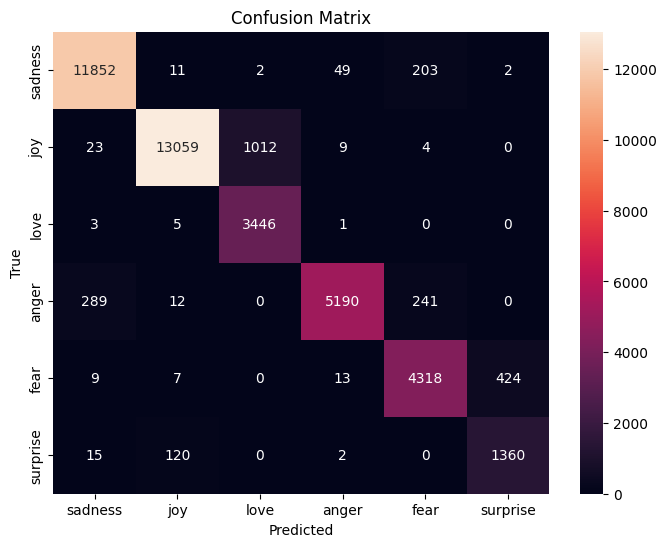

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

label_map = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

predictions_output = trainer.predict(tokenized_datasets["test"])
preds = predictions_output.predictions
labels = predictions_output.label_ids

predicted_labels = np.argmax(preds, axis=1)

true_label_names = [label_map[label] for label in labels]
pred_label_names = [label_map[label] for label in predicted_labels]

print(classification_report(true_label_names, pred_label_names))

cm = confusion_matrix(true_label_names, pred_label_names, labels=list(label_map.values()))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import shap

sample_texts = dataset["test"]["text"][:5]
model.to("cpu")

def model_predict(texts):
    texts = [str(t) for t in texts]

    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    return probs.cpu().numpy()

text_masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(model_predict, text_masker)

shap_values = explainer(sample_texts)

shap.plots.text(shap_values[0])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:45<00:05,  2.85s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:22<00:17, 17.07s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [01:39<00:00, 16.95s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [01:52, 22.60s/it]


In [ ]:
import torch
import torch.nn.functional as F

label_map = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

text = "I am graduating this semester let's organize a party! "

inputs = tokenizer(text, return_tensors="pt")

inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # shape: (1, num_labels)

probs = F.softmax(logits, dim=-1)  # shape: (1, num_labels)

probs = probs.cpu().numpy().flatten()

pred_label_idx = probs.argmax()

pred_label_str = label_map[pred_label_idx]

print(f"Input text: {text}\n")
print("Label probabilities:")
for i, prob in enumerate(probs):
    print(f"  {label_map[i]}: {prob:.4f}")

print(f"\nPredicted label: {pred_label_str} (index {pred_label_idx})")


Input text: I am graduating this semester let's organize a party! 

Label probabilities:
  sadness: 0.2513
  joy: 0.6493
  love: 0.0129
  anger: 0.0567
  fear: 0.0161
  surprise: 0.0137

Predicted label: joy (index 1)
